## pyBigWig

We can import the package using:

In [1]:
import pyBigWig

Now we are ready to play around with pyBigWig! We can open a BigWig file using:

In [2]:
bw = pyBigWig.open("/home/iker/GenomeDK/nnPib2019/data/training_data/C14M18.bigwig")

Let's first check is `bw` is really a BigWig file:

In [3]:
bw.isBigWig()

True

It is! Now, we can look at the different chromosomes in the file:

In [4]:
bw.chroms()

{'chr1': 248956422,
 'chr10': 133797422,
 'chr11': 135086622,
 'chr11_KI270721v1_random': 100316,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr14_GL000009v2_random': 201709,
 'chr14_GL000194v1_random': 191469,
 'chr14_GL000225v1_random': 211173,
 'chr14_KI270722v1_random': 194050,
 'chr14_KI270723v1_random': 38115,
 'chr14_KI270724v1_random': 39555,
 'chr14_KI270725v1_random': 172810,
 'chr14_KI270726v1_random': 43739,
 'chr15': 101991189,
 'chr15_KI270727v1_random': 448248,
 'chr16': 90338345,
 'chr16_KI270728v1_random': 1872759,
 'chr17': 83257441,
 'chr17_GL000205v2_random': 185591,
 'chr17_KI270729v1_random': 280839,
 'chr17_KI270730v1_random': 112551,
 'chr18': 80373285,
 'chr19': 58617616,
 'chr1_KI270706v1_random': 175055,
 'chr1_KI270708v1_random': 127682,
 'chr1_KI270709v1_random': 66860,
 'chr1_KI270711v1_random': 42210,
 'chr1_KI270712v1_random': 176043,
 'chr1_KI270713v1_random': 40745,
 'chr1_KI270714v1_random': 41717,
 'chr2': 242193529,
 'chr20': 6

If we want to know the length of a single chromosome we can use:

In [5]:
bw.chroms("chr22")

50818468

We can also check the header of the BigWig file:

In [6]:
bw.header()

{'version': 4,
 'nLevels': 10,
 'nBasesCovered': 3095449528,
 'minVal': 0,
 'maxVal': 36,
 'sumData': 1122619497,
 'sumSquared': 1773530499}

We can begin exploring our file. First, we can consult individual values by using:

In [7]:
bw.values("chr22", 0, 3)

[0.17124000191688538, 0.17124000191688538, 0.17124000191688538]

This gives us the first three values of chromosome 22. Instead, we might be interested in knowing the intervals, because some values might be repeated over a range.

In [8]:
bw.intervals("chr22", 0, 10712324)

((0, 10711304, 0.17124000191688538),
 (10711304, 10711373, 0.983299970626831),
 (10711373, 10712279, 0.17124000191688538),
 (10712279, 10712324, 0.07452999800443649))

The avobe code retrieves the intervals between the beginning of the chromosome up until position 10712324. If we want to include one more interval, we could try typing:

In [9]:
bw.intervals("chr22", 0, 10712325)

((0, 10711304, 0.17124000191688538),
 (10711304, 10711373, 0.983299970626831),
 (10711373, 10712279, 0.17124000191688538),
 (10712279, 10712324, 0.07452999800443649),
 (10712324, 10712428, 0.04546000063419342))

Many times we are interested in calculating the average over a range of values. For example:

In [10]:
bw.stats("chr22", 0, 10712324)

[0.17137697442745817]

We can also compute the maximum values over a range of values by using:

In [11]:
bw.stats("chr22", 10711304, 10712324, type='max')

[0.983299970626831]

In [12]:
lst = []

for i in bw.intervals("chr22"):
    lst.append(i[1] - i[0])

In [13]:
# bw.close()

In [14]:
len(lst)

1088622

In [15]:
lst[0:10]

[10711304, 69, 906, 45, 104, 23, 11, 1159, 132, 31]

## Pyfasta

This other package can be use to easily and efficiently access entries on a FASTA-encoded genome:

In [16]:
from pyfasta import Fasta

This command loads the FASTA file into Python (it takes roughly 30 minutes in my computer). The `key_fn` argument ensures to keep only the chromosome name, and not additional info:

In [17]:
f = Fasta('/home/iker/GenomeDK/nnPib2019/data/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta', key_fn=lambda key: key.split()[0])


We can see the keys of the FASTA file by using the following line:

In [18]:
sorted(f.keys())[0:10]

['chr1',
 'chr10',
 'chr11',
 'chr11_KI270721v1_random',
 'chr12',
 'chr13',
 'chr14',
 'chr14_GL000009v2_random',
 'chr14_GL000194v1_random',
 'chr14_GL000225v1_random']

We can access specific intervals of the FASTA file by specifying the name of the chromosome and the interval:

In [19]:
f['chr1'][1100023:1100033]

'GGAGGATCAC'

## Handling the data

In [20]:
import numpy as np
import pandas as pd
import itertools
from matplotlib import pyplot as plt
from tqdm import tqdm

We are interested in coding the nucleotides in the one-hot encoding. To do so, we can use `one_hot`. Note that missing values are encoded as all zeroes.

In [21]:
def one_hot(obs):
    '''Transforms a DNA sequence into the one-hot encoding.
    
    obs is a character string containing DNA nucleotides (A, C, G or T) or missing values (N). 
    It returns a single list containing one-hot encoded nucleotides.
    Note that missing values (N) are encoded as all zeroes.
    
    '''
    mapping = {'A': [1,0,0,0], 
               'C': [0,1,0,0], 
               'G': [0,0,1,0], 
               'T': [0,0,0,1], 
               'N': [0,0,0,0]}
    try:
        return list(itertools.chain.from_iterable([mapping[symbol.upper()] for symbol in obs]))
    except:
        print('Invalid DNA sequence')

In [22]:
one_hot(f['chr1'][1100023:1100033])

[0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0]

In [23]:
def slicing(bw, f, interval, chrom):
    dct = {'start': [], 'end':[], 'mean':[]}
    for i in range(interval, bw.chroms(chrom), interval):
        dct['start'].append(i-interval)
        dct['end'].append(i-1)
        dct['mean'].append(bw.stats(chrom, i-interval, i-1)[0])
    return pd.DataFrame.from_dict(dct)

In [24]:
data = slicing(bw, f, 1000, 'chr22')

In [25]:
data.shape

(50818, 3)

In [26]:
data.head()

,start,end,mean
0,0,999,0.17124
1,1000,1999,0.17124
2,2000,2999,0.17124
3,3000,3999,0.17124
4,4000,4999,0.17124


In [27]:
bw.values("chr22", 0, 1)

[0.17124000191688538]

In [28]:
f['chr1'][1100023]

'G'

In [29]:
index = [f['chr22'][i] != 'N' for i in tqdm(range(bw.chroms("chr22")))]

100%|██████████| 50818468/50818468 [02:38<00:00, 321521.80it/s]


In [30]:
data = bw.values("chr22", 0, bw.chroms("chr22"))

In [36]:
index[0:10]

[False, False, False, False, False, False, False, False, False, False]

In [38]:
import csv

In [39]:
with open('chr22.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(zip(data, index))

KeyboardInterrupt: 

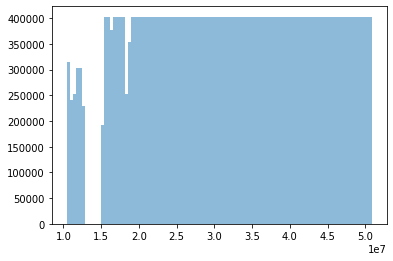

In [33]:
# fixed bin size
plt.hist(data, bins=100, alpha=0.5)

plt.show()